# Some exploration of methods

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_validate
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, SelectPercentile
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
from scipy.stats import pearsonr




In [4]:
# Prep data for XGBoost
mass_residuals = pd.read_csv('../data/mass_residuals_data_full.csv')

SNP_data = mass_residuals.iloc[:,7:]
SNP_data.fillna(0)
Y = mass_residuals.ID
SNP_data = OneHotEncoder(dtype=int).fit_transform(SNP_data)
print("Original shape:",SNP_data.shape)
sel = SelectPercentile(mutual_info_regression, percentile=10).fit(SNP_data, Y)
SNP_data = sel.transform(SNP_data)
print("Reduced shape:",SNP_data.shape)

/tmp/ipykernel_11308/3399288092.py:2: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  mass_residuals = pd.read_csv('../data/mass_residuals_data_full.csv')


Original shape: (1918, 729007)


ValueError: Unknown label type: (array([ 0.62151932, -1.25153788,  1.0989013 , ...,  0.61668636,
        0.59105605,  0.72076598]),)

In [17]:
SNP_data = OneHotEncoder(dtype=int).fit_transform(SNP_data.toarray())


In [23]:
print("Original shape:",SNP_data.shape)
sel = SelectPercentile(mutual_info_regression, percentile=10).fit(SNP_data.toarray(), Y)
SNP_data = sel.transform(SNP_data)
print("Reduced shape:",SNP_data.shape)

Original shape: (1918, 1458014)


KeyboardInterrupt: 

In [20]:
np.unique(SNP_data.toarray())

array([0, 1])

In [30]:
# hyperparameter tuning by baeysian optimization
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
    "max_depth": hp.choice("max_depth", range(1, 20)),
    "eta": hp.loguniform("eta", -5, -2),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "n_estimators": hp.choice("n_estimators", range(20, 205, 5)),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
}

def objective(params):
    xgb_r = XGBRegressor(**params)
    xgb_r.fit(X_train, y_train)
    y_pred = xgb_r.predict(X_val)  
    score = mean_squared_error(y_val, y_pred, squared=False)
    return {"loss": score, "status": STATUS_OK}

trials = Trials()  
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
print("Best Hyperparamters:",best)

100%|██████████| 100/100 [3:10:40<00:00, 114.41s/trial, best loss: 1.084202264642221] 
Best Hyperparamters: {'colsample_bytree': 0.7000000000000001, 'eta': 0.014921452492714465, 'max_depth': 11, 'n_estimators': 31, 'subsample': 0.7000000000000001}


In [31]:
final_xgb = XGBRegressor(**best)
final_xgb.fit(X_train_val, y_train_val)
y_pred = final_xgb.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print("Final RMSE:",score)

Final RMSE: 1.1949465525539724


In [ ]:
pickle.dump(final_xgb, open("../models/xgb_bayesoptim_noselection_full.pkl", "wb"))

In [8]:
# Plot feature importance
from scipy.stats import pearsonr
final_xgb = pickle.load(open("../models/xgb_bayesoptim_noselection_full.pkl", "rb"))
y_pred = final_xgb.predict(X_test)
corr = pearsonr(y_test, y_pred)
print("Pearson correlation coefficient:",corr[0])
print("p-value:",corr[1])

Pearson correlation coefficient: 0.2414227366768957
p-value: 1.6974773439872767e-06


In [54]:
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet, ElasticNetCV
import pandas as pd
import numpy as np

import urllib.request
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'}
word_url = "https://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain"
req = urllib.request.Request(word_url,headers = headers)
response = urllib.request.urlopen(req)
long_txt = response.read().decode()
words = long_txt.splitlines()[:100]

X,y = make_regression( noise=2)
reg = ElasticNetCV(cv = 5)
reg.fit(X,y)
X = pd.DataFrame(X, columns=words)
coefs = pd.Series(np.rint(reg.coef_), index=X.columns)

In [55]:
c = coefs[coefs!=0]
X = X[c.index]

In [56]:
c.sort_values(inplace=True)

print(c.head(int(len(c)*0.1)))
print(c.tail(int(len(c)*0.1)))

Abelson      -12.0
absentee     -12.0
abacus       -11.0
abnegation   -10.0
abbreviate   -10.0
Aaron         -9.0
abdicate      -9.0
Abernathy     -8.0
about         -8.0
dtype: float64
abort         11.0
Abraham       27.0
abominable    37.0
ablution      41.0
abide         43.0
abate         47.0
abolish       53.0
absorbent     61.0
abridge       62.0
dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corrs_df = pd.read_pickle("results/corrs_df.pkl")
MSE_df = pd.read_pickle("results/MSE_df.pkl")
feat_perc_df = pd.read_pickle("results/feat_perc_df.pkl")




In [17]:
dfs = [corrs_df, MSE_df, feat_perc_df]

for df in dfs:
    name_dict = {}
    for name in df.columns:
        if "CV" in name:
            new_name = name.split("CV")[0] + "Corr"
        else:
            new_name = name
        name_dict[name] = new_name
    df.rename(columns = name_dict, inplace=True)


In [14]:
name = "xgboostCVFeatureCorr"
if "CV" in name:
    new_name = name.split("CV")[0] + "Corr"
    print(new_name)

xgboostCorr


In [18]:
corrs_df

,lightGBMCorr,xgboostCorr,catboostCorr,xgboostElastic,catboostelasticCat,xgboostElasticCat
0,0.267440,0.312715,NaN,0.247491,0.241125,0.143307
1,0.302917,0.253613,0.312560,0.162350,0.130261,0.277261
2,0.297836,0.280342,0.171102,0.244005,0.276859,0.225144
3,0.155589,0.293251,0.252310,0.234472,0.203382,0.229642
4,0.150704,0.310041,0.291852,0.200042,0.229718,0.282589
5,0.310520,0.247407,0.210179,0.300575,0.279233,0.091988
6,0.238642,0.078389,0.315878,0.255406,0.220451,0.276869
7,0.241480,0.261212,0.303900,0.274448,0.181765,0.235801
8,0.199324,0.273106,0.377620,0.352574,0.239751,0.190617
9,0.272143,0.281295,0.302703,0.174938,NaN,0.227643


In [19]:
plot_df = pd.DataFrame(columns=["model", "corr", "MSE", "feat_perc", "phenotype"])
phenotype = "bodymass"
for name in corrs_df.columns:
    for i in range(corrs_df.shape[0]):
        plot_df.loc[len(plot_df)] = [name, corrs_df.iloc[i][name], MSE_df.iloc[i][name], feat_perc_df.iloc[i][name], phenotype]

In [23]:
mod_name = "catboostelasticCat"
plot_df = plot_df[plot_df.model != mod_name]
plot_df

,model,corr,MSE,feat_perc,phenotype
0,lightGBMCorr,0.267440,1.345832,0.101087,bodymass
1,lightGBMCorr,0.302917,1.337741,0.143436,bodymass
2,lightGBMCorr,0.297836,1.143844,0.149526,bodymass
3,lightGBMCorr,0.155589,1.626731,0.183524,bodymass
4,lightGBMCorr,0.150704,1.294193,0.234130,bodymass
5,lightGBMCorr,0.310520,1.310698,0.271659,bodymass
6,lightGBMCorr,0.238642,1.229222,0.314104,bodymass
7,lightGBMCorr,0.241480,1.532899,0.435675,bodymass
8,lightGBMCorr,0.199324,1.778913,0.536539,bodymass
9,lightGBMCorr,0.272143,1.284880,0.669402,bodymass


In [21]:
plot_df.to_pickle("results/plot_df.pkl")

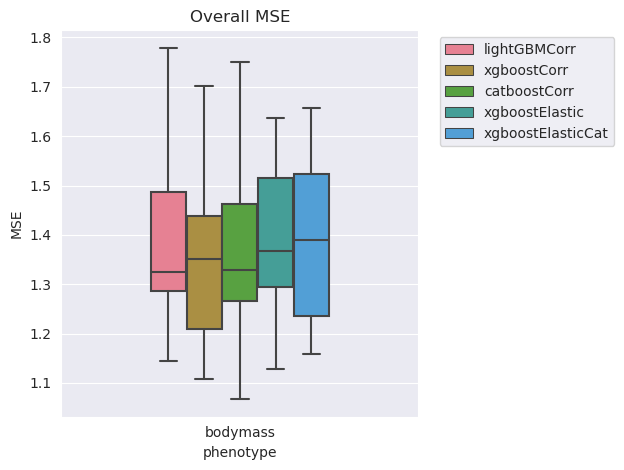

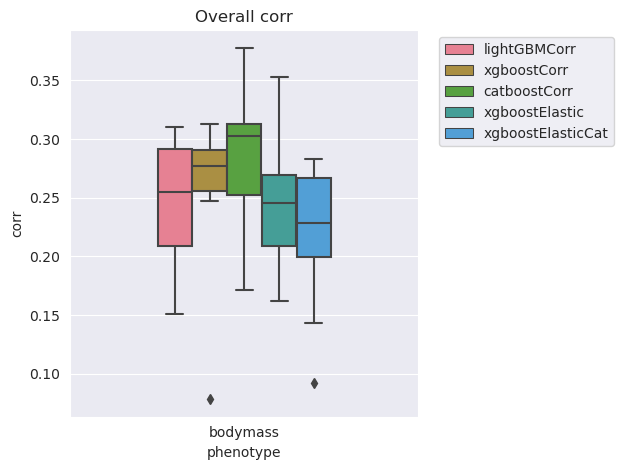

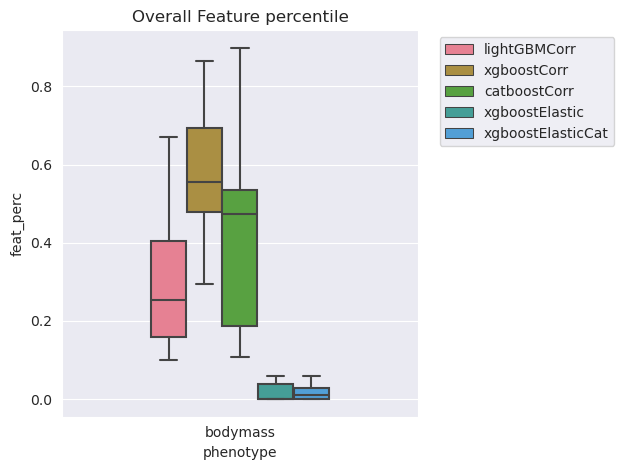

In [24]:
sns.set_style("darkgrid")
sns.set_palette(palette="husl")

plt.figure(4)
plt.title("Overall MSE")
sns.boxplot(data=plot_df,x="phenotype",y="MSE",hue="model",  orient = "v", width=.5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()

plt.figure(5)
plt.title("Overall corr")
sns.boxplot(data=plot_df,x="phenotype",y="corr",hue="model",  orient = "v", width=.5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()

plt.figure(6)
plt.title("Overall Feature percentile")
sns.boxplot(data=plot_df,x="phenotype",y="feat_perc",hue="model",  orient = "v", width=.5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()


In [1]:
import xgboost as xgb

xgb.__version__

'1.7.3'